In [ ]:
###Start
# coding: utf-8
print("-----------------------------")
print("Author: Giulio Giorcelli")
print("Algorithm: XGBoost regression to predict sales")
print("Last update: 07-23-2017")
print("-----------------------------\n")

In [2]:
import os
import pandas as pd
import xgboost as xgb
import numpy as np
import sys
import sklearn
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn import cross_validation, metrics   #Additional scklearn functions for CV, other stuff ##deprecated
from sklearn.grid_search import GridSearchCV  #Perforing grid search  ##deprecated
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [1]:
import os

In [2]:
os.environ

environ({'ALLUSERSPROFILE': 'C:\\ProgramData', 'APPDATA': 'C:\\Users\\ggiorcelli\\AppData\\Roaming', 'COMMONPROGRAMFILES': 'C:\\Program Files\\Common Files', 'COMMONPROGRAMFILES(X86)': 'C:\\Program Files (x86)\\Common Files', 'COMMONPROGRAMW6432': 'C:\\Program Files\\Common Files', 'COMPUTERNAME': 'BCOLT-GGIOR', 'COMSPEC': 'C:\\windows\\system32\\cmd.exe', 'DATACONNECTORLIBPATH': 'C:\\Program Files\\Teradata\\Client\\15.10\\bin\\;C:\\Program Files (x86)\\Teradata\\Client\\15.10\\bin\\', 'HOMEDRIVE': 'C:', 'HOMEPATH': '\\Users\\ggiorcelli', 'LOCALAPPDATA': 'C:\\Users\\ggiorcelli\\AppData\\Local', 'LOGONSERVER': '\\\\HHC-AD-02', 'NUMBER_OF_PROCESSORS': '8', 'ONEDRIVE': 'C:\\Users\\ggiorcelli\\OneDrive', 'OS': 'Windows_NT', 'PATH': 'C:\\Users\\ggiorcelli\\AppData\\Local\\Continuum\\Anaconda3\\Library\\bin;C:\\Users\\ggiorcelli\\AppData\\Local\\Continuum\\Anaconda3\\Library\\bin;C:\\Users\\ggiorcelli\\AppData\\Local\\Continuum\\Anaconda3;C:\\Users\\ggiorcelli\\AppData\\Local\\Continuum\\An

In [4]:
#New import cell
from sklearn.learning_curve import validation_curve
from sklearn.datasets import load_svmlight_files
from sklearn.datasets import (make_classification, make_regression)
from sklearn.cross_validation import StratifiedKFold
from scipy import vstack 
import matplotlib.pyplot as plt2

#Ensuring reproducibilty
seed = 123
np.random.seed(seed)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [6]:
df = pd.read_csv("/Users/ggiorcelli/desktop/data_for_model/us_dealer_data2.csv", sep=",")
df.head()

,Unnamed: 0,lead_cdd_id,zip,lead_yearmonth,total_leads,total_sales,code_1_sales,code_2_sales,code_3_sales,seasonality_index,forecast_leads,dma_name,close_rate,dma_size,new_inv,used_inv
0,1,100,35233,201609,1,0,0,0,0,0.964,13,BIRMINGHAM (ANN AND TUSC),0.000000,1,139,89
1,2,100,35233,201611,3,0,0,0,0,0.896,13,BIRMINGHAM (ANN AND TUSC),0.000000,1,127,98
2,3,100,35233,201612,1,0,0,0,0,1.002,13,BIRMINGHAM (ANN AND TUSC),0.000000,1,144,86
3,4,1000,91204,201601,41,11,1,4,6,1.011,40,LOS ANGELES,0.268293,4,427,150
4,5,1000,91204,201602,34,14,1,8,5,0.923,40,LOS ANGELES,0.411765,4,350,151


In [5]:
type(df)

pandas.core.frame.DataFrame

In [7]:
df.drop(df.columns[0],axis=1,inplace=True)
df.head()

,lead_cdd_id,zip,lead_yearmonth,total_leads,total_sales,code_1_sales,code_2_sales,code_3_sales,seasonality_index,forecast_leads,dma_name,close_rate,dma_size,new_inv,used_inv
0,100,35233,201609,1,0,0,0,0,0.964,13,BIRMINGHAM (ANN AND TUSC),0.000000,1,139,89
1,100,35233,201611,3,0,0,0,0,0.896,13,BIRMINGHAM (ANN AND TUSC),0.000000,1,127,98
2,100,35233,201612,1,0,0,0,0,1.002,13,BIRMINGHAM (ANN AND TUSC),0.000000,1,144,86
3,1000,91204,201601,41,11,1,4,6,1.011,40,LOS ANGELES,0.268293,4,427,150
4,1000,91204,201602,34,14,1,8,5,0.923,40,LOS ANGELES,0.411765,4,350,151


In [8]:
train = df
train.head()

cols = [1,2,5,6,7,10]
train.drop(df.columns[cols],axis=1,inplace=True)
train.drop('close_rate',axis=1,inplace=True)
train.head()

,lead_cdd_id,total_leads,total_sales,seasonality_index,forecast_leads,dma_size,new_inv,used_inv
0,100,1,0,0.964,13,1,139,89
1,100,3,0,0.896,13,1,127,98
2,100,1,0,1.002,13,1,144,86
3,1000,41,11,1.011,40,4,427,150
4,1000,34,14,0.923,40,4,350,151


In [9]:
#target = 'total_sales'
#IDcol = 'lead_cdd_id'

In [ ]:
##Don't run this
#from sklearn.model_selection import train_test_split
#train, test = train_test_split(df, test_size = 0.2)

In [10]:
##Function below splits data into train, test and validate
##Maybe I'll never use it

def train_validate_test_split(df, train_percent=.7, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.ix[perm[:train_end]]
    validate = df.ix[perm[train_end:validate_end]]
    test = df.ix[perm[validate_end:]]
    return train, validate, test
  
train, validate, test = train_validate_test_split(df)

In [10]:
train.head()
train.shape()

(52428, 8)

In [11]:
##Building modelfit function
##This function builds XGboost models and performs 5-fold CVs
##Early stopping set to 25 rounds
##metrics='auc', eval_metric

def apply_xgboost(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=25):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['total_sales'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    #print("Explained Variance Score : %.4g" % metrics.explained_variance_score(dtrain['total_sales'].values, dtrain_predictions))
    print("R^2 Score : %.4g" % metrics.r2_score(dtrain['total_sales'].values, dtrain_predictions))
    print("Mean Square Error : %.4g" % metrics.mean_squared_error(dtrain['total_sales'].values, dtrain_predictions))
    print("Median Absolute Error : %.4g" % metrics.median_absolute_error(dtrain['total_sales'].values, dtrain_predictions))
    print("Mean Absolute Error : %.4g" % metrics.mean_absolute_error(dtrain['total_sales'].values, dtrain_predictions))
    
    
    #print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['total_sales'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [24]:
apply_xgboost

<function __main__.modelfit>

In [12]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]

#Build model
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 silent=False,   
 seed=27)

predictors

['total_leads',
 'seasonality_index',
 'forecast_leads',
 'dma_size',
 'new_inv',
 'used_inv']

In [ ]:
######Begin step-by-step section
##For my own sake, I'm running every step in the function by itself
##This section can be skipped if you are using the modelfit function

In [13]:
xgb_param = xgb1.get_xgb_params()
xgb_param

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 1000,
 'nthread': 4,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 27,
 'silent': 0,
 'subsample': 0.8}

In [84]:
xgtrain = xgb.DMatrix(train[predictors].values, label=train[target].values)
xgtrain

In [86]:
cvresult = xgb.cv(xgb_param, xgtrain, 
           num_boost_round=xgb1.get_params()['n_estimators'],
           nfold=5, early_stopping_rounds=25)
cvresult

In [87]:
xgb1.set_params(n_estimators=cvresult.shape[0])

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

In [90]:
xgb1.fit(train[predictors], train['total_sales'])
predictions = xgb1.predict(train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

In [ ]:
#######End step-by-step section
## Everything looks good


Model Report
R^2 Score : 0.9561
Mean Square Error : 7.058
Median Absolute Error : 1.09
Mean Absolute Error : 1.784


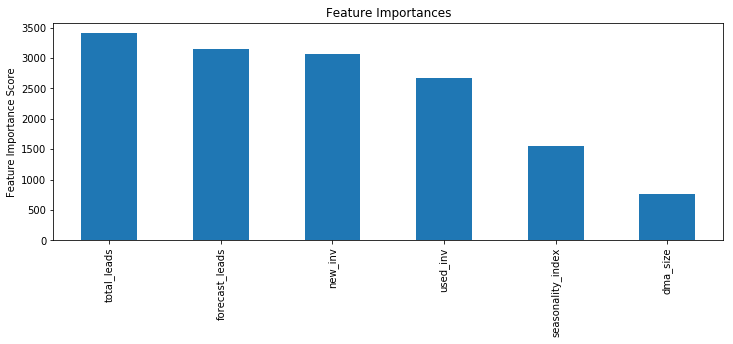

In [14]:
##Running model
#This function outputs a complete model report and feature importances
apply_xgboost(xgb1, train, predictors)

In [17]:
####Beginning paramenter tuning
##In this section I'll tune max_dept and min_child_weight

param_test1 = {
 'max_depth': [3,5,7,10],
 'min_child_weight': [1,3,5]
}

gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1 , scoring='neg_mean_squared_error',n_jobs=4, iid=False, cv=5)

In [18]:
gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=140, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [3, 5, 7, 10], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [141]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -1.26080, std: 0.02856, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -1.26183, std: 0.03049, params: {'max_depth': 3, 'min_child_weight': 6},
  mean: -1.26013, std: 0.03230, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: -1.21502, std: 0.02155, params: {'max_depth': 10, 'min_child_weight': 1},
  mean: -1.20877, std: 0.02260, params: {'max_depth': 10, 'min_child_weight': 6},
  mean: -1.21997, std: 0.02078, params: {'max_depth': 10, 'min_child_weight': 2},
  mean: -1.28818, std: 0.02826, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: -1.29063, std: 0.03368, params: {'max_depth': 2, 'min_child_weight': 6},
  mean: -1.28831, std: 0.03846, params: {'max_depth': 2, 'min_child_weight': 2}],
 {'max_depth': 10, 'min_child_weight': 6},
 -1.2087743639945985)

In [34]:
#Iteration 2
param_test2 = {
 'max_depth': [7,8,9],
 'min_child_weight': [4,5,6]
}

gsearch2 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2 , scoring='neg_median_absolute_error',n_jobs=4, iid=False, cv=5)

In [35]:
gsearch2.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=140, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [7, 8, 9], 'min_child_weight': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_median_absolute_error', verbose=0)

In [36]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: -1.19754, std: 0.02809, params: {'max_depth': 7, 'min_child_weight': 4},
  mean: -1.19576, std: 0.02757, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -1.19667, std: 0.02745, params: {'max_depth': 7, 'min_child_weight': 6},
  mean: -1.19878, std: 0.03341, params: {'max_depth': 8, 'min_child_weight': 4},
  mean: -1.19466, std: 0.03048, params: {'max_depth': 8, 'min_child_weight': 5},
  mean: -1.19595, std: 0.03025, params: {'max_depth': 8, 'min_child_weight': 6},
  mean: -1.21366, std: 0.03470, params: {'max_depth': 9, 'min_child_weight': 4},
  mean: -1.20906, std: 0.03559, params: {'max_depth': 9, 'min_child_weight': 5},
  mean: -1.21111, std: 0.03036, params: {'max_depth': 9, 'min_child_weight': 6}],
 {'max_depth': 8, 'min_child_weight': 5},
 -1.194655442237854)

In [ ]:
##Max_depth optimal value = 8
##Min_child_weight optimal value = 5
#### Min_child_weight an max_depth have been tuned

In [40]:
##Tuning gamma
param_test3 = {
    'gamma' : [i/10.0 for i in range(0,7)]
}

gsearch3 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=8,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test3 , scoring='neg_median_absolute_error',n_jobs=4, iid=False, cv=5)

In [41]:
gsearch3.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=5, missing=None, n_estimators=140, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_median_absolute_error', verbose=0)

In [42]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -1.19466, std: 0.03048, params: {'gamma': 0.0},
  mean: -1.20012, std: 0.02864, params: {'gamma': 0.1},
  mean: -1.20014, std: 0.03074, params: {'gamma': 0.2},
  mean: -1.19972, std: 0.03495, params: {'gamma': 0.3},
  mean: -1.20232, std: 0.03017, params: {'gamma': 0.4},
  mean: -1.19661, std: 0.02894, params: {'gamma': 0.5},
  mean: -1.19809, std: 0.03288, params: {'gamma': 0.6}],
 {'gamma': 0.0},
 -1.194655442237854)

In [45]:
#Inserting newly tuned parameters in the model
xgb2 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=8,
 min_child_weight=5,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 silent=False,   
 seed=27)



Model Report
Explained Variance Score : 0.9672
R^2 Score : 0.9672
Mean Square Error : 5.339
Median Absolute Error : 1.017
Mean Absolute Error : 1.587


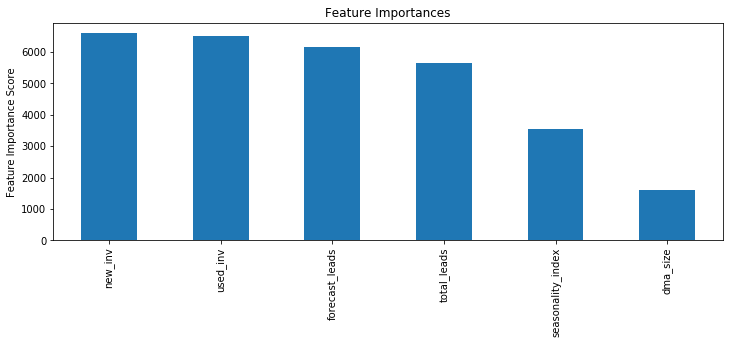

In [46]:
###xgb1 model report
#Explained Variance Score : 0.9592
#R^2 Score : 0.9592
#Mean Square Error : 6.442
#Median Absolute Error : 1.08
#Mean Absolute Error : 1.724

apply_xgboost(xgb2, train, predictors)

In [ ]:
#Good improvement, feature importances also changed

In [47]:
##Now let's tune subsample and colsample_bytree
param_test4 = {
    'subsample' : [i/10.0 for i in range(6,10)],
    'colsample_bytree': [i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=8,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4 , scoring='neg_median_absolute_error',n_jobs=4, iid=False, cv=5)

In [48]:
gsearch4.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=5, missing=None, n_estimators=140, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_median_absolute_error', verbose=0)

In [49]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: -1.24597, std: 0.01351, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -1.24821, std: 0.01701, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -1.24533, std: 0.01791, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -1.24209, std: 0.01395, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: -1.20824, std: 0.03620, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -1.20238, std: 0.03433, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -1.19466, std: 0.03048, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: -1.19784, std: 0.03125, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: -1.20824, std: 0.03620, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: -1.20238, std: 0.03433, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: -1.19466, std: 0.03048, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: -1.19784, std: 0.03125, params: {'colsample_bytree': 0.8,

In [115]:
#Iteration 2
param_test5 = {
    'subsample' : [i/10.0 for i in range(4,10)],
    'colsample_bytree': [i/10.0 for i in range(8,10)]
}

gsearch5 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=8,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test5 , scoring='neg_mean_absolute_error',n_jobs=4, iid=False, cv=5)

In [ ]:
gsearch5.fit(train[predictors],train[target])

In [57]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: -1.22303, std: 0.03680, params: {'colsample_bytree': 0.8, 'subsample': 0.4},
  mean: -1.20667, std: 0.03010, params: {'colsample_bytree': 0.8, 'subsample': 0.5},
  mean: -1.20824, std: 0.03620, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: -1.20238, std: 0.03433, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: -1.19466, std: 0.03048, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: -1.19784, std: 0.03125, params: {'colsample_bytree': 0.8, 'subsample': 0.9},
  mean: -1.16849, std: 0.01799, params: {'colsample_bytree': 0.9, 'subsample': 0.4},
  mean: -1.16806, std: 0.01210, params: {'colsample_bytree': 0.9, 'subsample': 0.5},
  mean: -1.16407, std: 0.00985, params: {'colsample_bytree': 0.9, 'subsample': 0.6},
  mean: -1.15800, std: 0.01330, params: {'colsample_bytree': 0.9, 'subsample': 0.7},
  mean: -1.15904, std: 0.01816, params: {'colsample_bytree': 0.9, 'subsample': 0.8},
  mean: -1.16087, std: 0.01892, params: {'colsample_bytree': 0.9,

In [61]:
#Now let's try to improve some more by looking at 0.05 intervals

param_test5b = {
 'subsample':[i/100.0 for i in range(60,95,5)],
 'colsample_bytree':[i/100.0 for i in range(65,95,5)]
}
gsearch5b = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=8,
 min_child_weight=5, gamma=0, subsample=0.7, colsample_bytree=0.9,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test5b , scoring='neg_median_absolute_error',n_jobs=4, iid=False, cv=5)

In [62]:
gsearch5b.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=5, missing=None, n_estimators=140, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.7),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9], 'colsample_bytree': [0.65, 0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_median_absolute_error', verbose=0)

In [63]:
gsearch5b.grid_scores_, gsearch5b.best_params_, gsearch5b.best_score_

([mean: -1.24597, std: 0.01351, params: {'colsample_bytree': 0.65, 'subsample': 0.6},
  mean: -1.25196, std: 0.01643, params: {'colsample_bytree': 0.65, 'subsample': 0.65},
  mean: -1.24821, std: 0.01701, params: {'colsample_bytree': 0.65, 'subsample': 0.7},
  mean: -1.24704, std: 0.01860, params: {'colsample_bytree': 0.65, 'subsample': 0.75},
  mean: -1.24533, std: 0.01791, params: {'colsample_bytree': 0.65, 'subsample': 0.8},
  mean: -1.24148, std: 0.01442, params: {'colsample_bytree': 0.65, 'subsample': 0.85},
  mean: -1.24209, std: 0.01395, params: {'colsample_bytree': 0.65, 'subsample': 0.9},
  mean: -1.20824, std: 0.03620, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -1.19872, std: 0.03093, params: {'colsample_bytree': 0.7, 'subsample': 0.65},
  mean: -1.20238, std: 0.03433, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -1.19832, std: 0.03422, params: {'colsample_bytree': 0.7, 'subsample': 0.75},
  mean: -1.19466, std: 0.03048, params: {'colsample_b

In [ ]:
#Tuning for these parameters has been finilized.
#colsample_bytree : 0.85
#subsample: 0.75

In [ ]:
#With gamma==0 we are already controlling complexity pretty well
#Now I'll tune the regularization paramenter alpha to reduce overfitting

In [65]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=8,
 min_child_weight=5, gamma=0, subsample=0.75, colsample_bytree=0.85,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test6 , scoring='neg_median_absolute_error',n_jobs=4, iid=False, cv=5)

In [66]:
gsearch6.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.85,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=5, missing=None, n_estimators=140, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.75),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_median_absolute_error', verbose=0)

In [67]:
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: -1.15585, std: 0.01773, params: {'reg_alpha': 1e-05},
  mean: -1.16046, std: 0.01948, params: {'reg_alpha': 0.01},
  mean: -1.15892, std: 0.01774, params: {'reg_alpha': 0.1},
  mean: -1.15976, std: 0.01223, params: {'reg_alpha': 1},
  mean: -1.16648, std: 0.01917, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 -1.155845046043396)

In [ ]:
#Not let's close up on 0.00001

In [68]:
param_test6b = {
 'reg_alpha':[0, 0.0006, 0.0005, 0.0003, 0.0001]
}
gsearch6b = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=8,
 min_child_weight=5, gamma=0, subsample=0.75, colsample_bytree=0.85,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test6b , scoring='neg_median_absolute_error',n_jobs=4, iid=False, cv=5)

In [69]:
gsearch6b.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.85,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=5, missing=None, n_estimators=140, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.75),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [0, 0.0006, 0.0005, 0.0003, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_median_absolute_error', verbose=0)

In [70]:
gsearch6b.grid_scores_, gsearch6b.best_params_, gsearch6b.best_score_

([mean: -1.15585, std: 0.01773, params: {'reg_alpha': 0},
  mean: -1.15734, std: 0.01949, params: {'reg_alpha': 0.0006},
  mean: -1.15777, std: 0.01879, params: {'reg_alpha': 0.0005},
  mean: -1.15528, std: 0.01715, params: {'reg_alpha': 0.0003},
  mean: -1.15584, std: 0.01773, params: {'reg_alpha': 0.0001}],
 {'reg_alpha': 0.0003},
 -1.155277633666992)

In [ ]:
##Optimal alpha value is 0.0003

In [ ]:
##Now I'll update and run the model with the new parameters

In [71]:
xgb3 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=8,
 min_child_weight=5,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.85,
 reg_alpha=0.0003,   
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 silent=False,   
 seed=27)


Model Report
R^2 Score : 0.9676
Mean Square Error : 5.276
Median Absolute Error : 1.007
Mean Absolute Error : 1.576


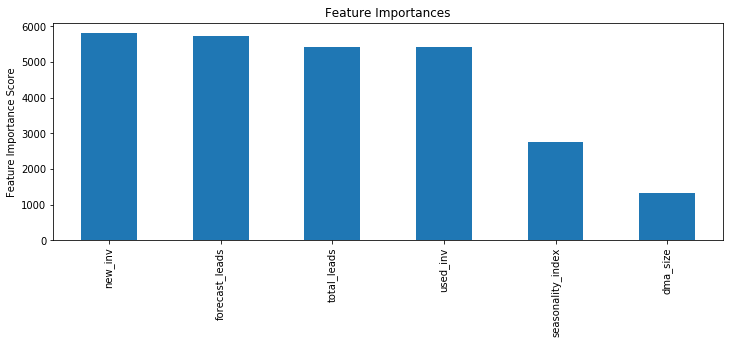

In [72]:
apply_xgboost(xgb3, train, predictors)
#Old model report
#Explained Variance Score : 0.9672
#R^2 Score : 0.9672
#Mean Square Error : 5.339
#Median Absolute Error : 1.017
#Mean Absolute Error : 1.587

In [ ]:
#The model as slightly improved
#Now I'll slow down the learning rate and increase the number of trees to fully implement the newly tuned paramenters

In [13]:
xgb4 = XGBRegressor(
 learning_rate =0.05,
 n_estimators=5000,
 max_depth=8,
 min_child_weight=5,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.85,
 reg_alpha=0.0003,   
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 silent=0,   
 seed=27)


Model Report
R^2 Score : 0.9673
Mean Square Error : 5.289
Median Absolute Error : 0.9954
Mean Absolute Error : 1.573


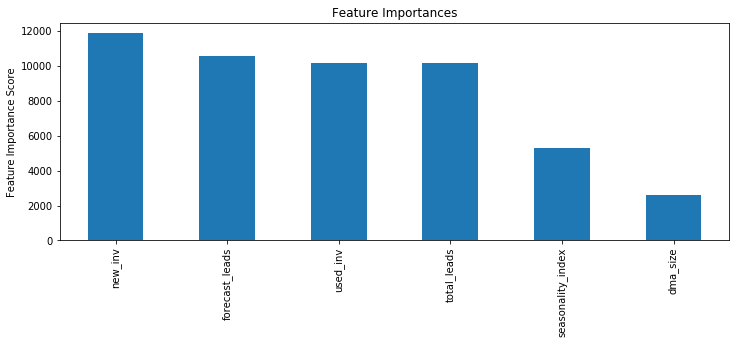

In [14]:
apply_xgboost(xgb4, train, predictors)
#Previous Model Report
#R^2 Score : 0.9676
#Mean Square Error : 5.276
#Median Absolute Error : 1.007
#Mean Absolute Error : 1.576

In [ ]:
##Major improvement, sub 1 Median Absolute Error has been achieved

In [22]:
#from sklearn.model_selection import train_test_split
#train, test = train_test_split(df, test_size = 0.2)

In [49]:
X1, y1 = make_classification(n_samples=1000, n_features=20, n_informative=4, random_state=seed)

In [50]:
cv = StratifiedKFold(y1, n_folds=5, shuffle=True, random_state=seed)

In [141]:
default_params = {
 'learning_rate': 0.05,
 'n_estimators': 5000,
 'max_depth': 8,
 'min_child_weight': 5,
 'gamma': 0,
 'subsample': 0.75,
 'colsample_bytree': 0.85,
 'reg_alpha': 0.0003,   
 'objective' : 'reg:linear',
 'nthread': 4,
 'scale_pos_weight' : 1,
 'silent': 1
}

In [142]:
n_estimators_range = np.linspace(1,200,10).astype('int')

In [143]:
train_scores, test_scores = validation_curve(
        xgb4,
        X1, y1,
        param_name = 'n_estimators',
        param_range = n_estimators_range,
        cv=cv,
        scoring = 'neg_mean_squared_error'
)

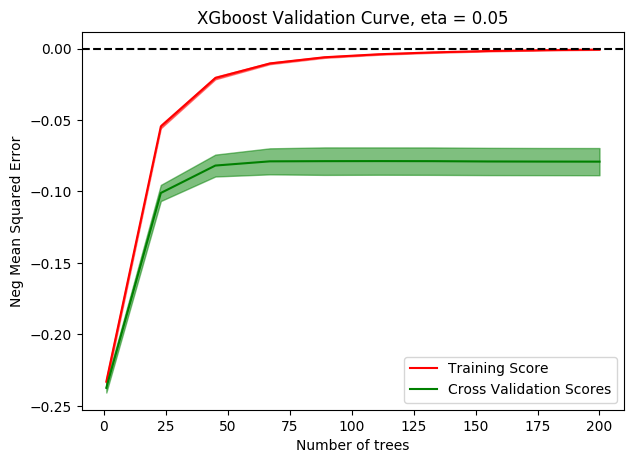

Best Cross-Validation Results (-0.08) obtained for 111 tree


In [145]:
train_scores_mean = np.mean(train_scores, axis = 1)
train_scores_std = np.std(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)
test_scores_std = np.std(test_scores, axis = 1)

fig = plt2.figure(figsize=(7,5), dpi=100)

plt2.title('XGboost Validation Curve, eta = 0.05')
plt2.xlabel('Number of trees')
plt2.ylabel('Neg Mean Squared Error')

plt2.plot(n_estimators_range, train_scores_mean,
          label= 'Training Score', color = 'r' )

plt2.plot(n_estimators_range, test_scores_mean,
          label= 'Cross Validation Scores', color = 'g' )

plt2.fill_between(n_estimators_range,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.5, color = 'r')

plt2.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.5, color = 'g')

plt2.axhline(y=0.0, color='k', ls='dashed')
plt2.legend(loc='best')
plt2.show()

i = np.argmax(test_scores_mean)
print("Best Cross-Validation Results ({0:.2f}) obtained for {1} tree".format(test_scores_mean[i], n_estimators_range[i]))